## Based on: http://www.bmva.org/bmvc/2015/papers/paper109/paper109.pdf

In [68]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [50, 10]
from PIL import Image
from PIL import ImageOps
from PIL import Image, ImageDraw
import seaborn as sn
import numpy as np
import pandas as pd
from flow_from_dataframe import flow_from_dataframe
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
%matplotlib inline

In [2]:
KITTI_IMAGE_WIDTH = 1242
STIXEL_WIDTH = 24
IMAGE_SIZE = (370,STIXEL_WIDTH)
maximum_offset = KITTI_IMAGE_WIDTH//STIXEL_WIDTH 
BATCH_SIZE = 30
NUMBER_OF_BINS = 50

In [3]:
df = pd.read_csv('data_train/labels_no.csv')
# bin labels
bins = np.linspace(0, 370, NUMBER_OF_BINS)
binned_values = []
for index, row in df.iterrows():
    binned_values.append(np.argmax(np.histogram(row['y'],bins)[0]))
df['binned_y'] = pd.Series(binned_values)
df.head()

img_path    y  binned_y
0  data_train/stixels/2.png  242        32
1  data_train/stixels/3.png  237        31
2  data_train/stixels/4.png  236        31
3  data_train/stixels/5.png  229        30
4  data_train/stixels/6.png  229        30

In [4]:
train_df, valid_df = train_test_split(df, test_size = 0.1, random_state = 1337)

core_idg = ImageDataGenerator(
    horizontal_flip = True,
    rescale=1.0/255.0)

train_generator = flow_from_dataframe(
    core_idg,df,
    'img_path',
    'binned_y',
    'data_train/',
    NUMBER_OF_BINS,
    target_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE)
test_generator = flow_from_dataframe(
    core_idg,valid_df,
    'img_path',
    'binned_y',
    'data_train/',
    NUMBER_OF_BINS,
    target_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE)

Found 355366 images belonging to 1 classes.
Found 355366 images belonging to 1 classes.


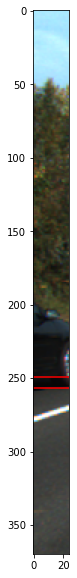

In [5]:
plt.rcParams['figure.figsize'] = [20, 10]

i=0
for t in train_generator:
    plt.imshow(t[0][0])
    for j in range(len(t[1][0])):
        if t[1][0][j] == 1:
            plt.axhline(y=bins[j],color='red')
            plt.axhline(y=bins[j+1],color='red')
    plt.show()
    break

In [6]:
import tensorflow as tf
import keras.backend as K


# Ground truth needs to be in that form: [ACTUAL_VALUE,BIN_OF_ACTUAL_VALUE, (NUMBER_OF_BINS-2)*Zero (zero padding)]
# This is due to keras demanding dim(y_true) == dim(y_pred) But in this case this is not wanted.
# Current notebook DOES NOT generate y_true in that manner, since this loss function is not working (for now).

def P(y,y_pred,i):
    i_1 = i+1
    a_i = K.cast(K.gather(y_pred,i),'float32')
    a_i_1 = K.cast(K.gather(y_pred,i_1),'float32')
    c_i = K.cast(K.gather(bins,i),'float32')
    c_i_1 = K.cast(K.gather(bins,i_1),'float32')
    denominator = c_i_1 - c_i
    first_half = a_i * (((c_i_1 - y) / denominator))
    second_half = a_i_1 * ((y - c_i) / denominator)
    return  first_half + second_half

def pl_loss(y_true,y_pred):
    y_true = K.cast(K.gather(y_true,0),'float32')
    y_pred = K.cast(K.flatten(y_pred),"float32")
    i = K.cast(K.gather(K.flatten(y_true),1),'int32')
    return P(y_true,y_pred,i)

In [7]:
from keras.layers import Input,Conv2D,MaxPooling2D,Dense,Dropout,Flatten
from keras import Model
from keras.optimizers import Adam

def StixelNet(loss='mean_squared_error',metrics=['accuracy'],number_of_bins=50):
    inputs = Input((IMAGE_SIZE[0],IMAGE_SIZE[1],3))
    conv1 = Conv2D(64, (5,11), activation='relu',padding='same', kernel_initializer='he_normal')(inputs)
    pool1 = MaxPooling2D(pool_size=(4, 8))(conv1)
    conv2 = Conv2D(200, (3,5), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(4, 3))(conv2)
    flattened = Flatten()(pool2)
    dense1 = Dense(1024, kernel_initializer='he_normal', activation='relu')(flattened)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(2048, kernel_initializer='he_normal', activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    dense3 = Dense(number_of_bins, kernel_initializer='he_normal', activation='softmax')(dropout2)
    model = Model(inputs=inputs, outputs=dense3)
    model.compile(optimizer=Adam(lr=0.001), loss=loss, metrics=metrics)
    return model

In [11]:
model = StixelNet(number_of_bins=NUMBER_OF_BINS,metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy()])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 370, 24, 3)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 370, 24, 64)       10624     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 92, 3, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 92, 3, 200)        192200    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 1, 200)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              4711

In [13]:
steps_per_epoch = train_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE

checkpoint = ModelCheckpoint(
    "best_model.hdf5", 
    monitor='val_loss',
    verbose=1,
    save_best_only=True, 
    mode='min', 
    period=1, 
    save_weights_only=True)

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=50,
                              validation_data=test_generator,
                              validation_steps=test_steps,
                              callbacks=[checkpoint])

Epoch 1/50
3941/3941 [==============================] - 160s 41ms/step - loss: 0.0123 - accuracy: 0.5197 - top_k_categorical_accuracy: 0.8808 - val_loss: 0.0143 - val_accuracy: 0.5538 - val_top_k_categorical_accuracy: 0.8809

Epoch 00001: val_loss improved from inf to 0.01432, saving model to best_model.hdf5
Epoch 2/50
3941/3941 [==============================] - 159s 40ms/step - loss: 0.0123 - accuracy: 0.5213 - top_k_categorical_accuracy: 0.8809 - val_loss: 0.0110 - val_accuracy: 0.5793 - val_top_k_categorical_accuracy: 0.8810

Epoch 00002: val_loss improved from 0.01432 to 0.01098, saving model to best_model.hdf5
Epoch 3/50
3941/3941 [==============================] - 151s 38ms/step - loss: 0.0123 - accuracy: 0.5197 - top_k_categorical_accuracy: 0.8810 - val_loss: 0.0126 - val_accuracy: 0.5752 - val_top_k_categorical_accuracy: 0.8811

Epoch 00003: val_loss did not improve from 0.01098
Epoch 4/50
3941/3941 [==============================] - 154s 39ms/step - loss: 0.0123 - accuracy: 0

3941/3941 [==============================] - 145s 37ms/step - loss: 0.0117 - accuracy: 0.5483 - top_k_categorical_accuracy: 0.8821 - val_loss: 0.0129 - val_accuracy: 0.5941 - val_top_k_categorical_accuracy: 0.8820

Epoch 00029: val_loss did not improve from 0.00906
Epoch 30/50
3941/3941 [==============================] - 158s 40ms/step - loss: 0.0117 - accuracy: 0.5486 - top_k_categorical_accuracy: 0.8821 - val_loss: 0.0152 - val_accuracy: 0.6151 - val_top_k_categorical_accuracy: 0.8820

Epoch 00030: val_loss did not improve from 0.00906
Epoch 31/50
3941/3941 [==============================] - 154s 39ms/step - loss: 0.0116 - accuracy: 0.5490 - top_k_categorical_accuracy: 0.8820 - val_loss: 0.0095 - val_accuracy: 0.6103 - val_top_k_categorical_accuracy: 0.8820

Epoch 00031: val_loss did not improve from 0.00906
Epoch 32/50
3941/3941 [==============================] - 142s 36ms/step - loss: 0.0117 - accuracy: 0.5492 - top_k_categorical_accuracy: 0.8820 - val_loss: 0.0132 - val_accuracy: 

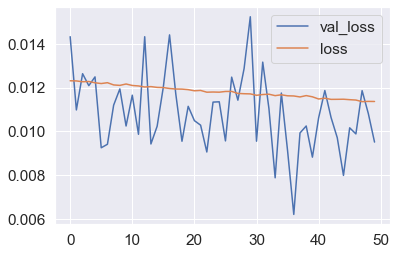

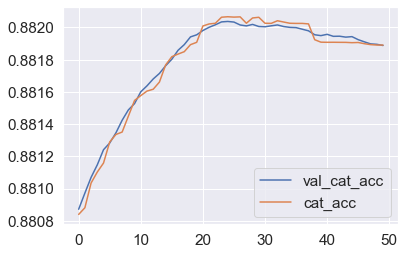

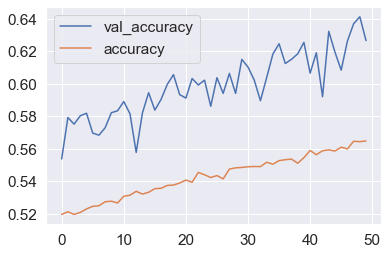

In [85]:
plt.plot(history.history.get('val_loss'),label='val_loss')
plt.plot(history.history.get('loss'),label='loss')
plt.legend()
plt.show()

plt.plot(history.history.get('val_top_k_categorical_accuracy'),label='val_cat_acc')
plt.plot(history.history.get('top_k_categorical_accuracy'),label='cat_acc')
plt.legend()
plt.show()

plt.plot(history.history.get('val_accuracy'),label='val_accuracy')
plt.plot(history.history.get('accuracy'),label='accuracy')
plt.legend()
plt.show()


In [15]:
model.load_weights('best_model.hdf5')

[0.00015674511, 8.631161e-07, 0.00039813833, 0.0006321625, 5.5679398e-06, 2.3877616e-05, 3.6649704e-05, 1.8163426e-21, 5.4521752e-21, 7.6260216e-22, 6.346745e-22, 5.6909605e-05, 2.7429186e-20, 0.00013650914, 5.9594586e-05, 7.7165334e-22, 6.110752e-05, 0.00042660107, 7.1191736e-21, 5.769063e-22, 2.821283e-17, 0.0008443827, 8.005905e-25, 9.845368e-32, 2.2734216e-20, 8.260997e-11, 5.0845436e-05, 0.9938691, 0.0007402029, 2.6215725e-09, 5.6952045e-13, 4.163807e-14, 5.3189455e-16, 1.1181724e-19, 4.7558914e-20, 3.4445255e-21, 6.552638e-21, 1.0455419e-24, 1.269131e-26, 1.1865706e-27, 3.0591507e-29, 2.5775387e-28, 3.0226342e-29, 3.06396e-38, 0.0, 8.5329915e-10, 4.3530366e-05, 0.0012905439, 1.4343385e-06, 0.001165148]


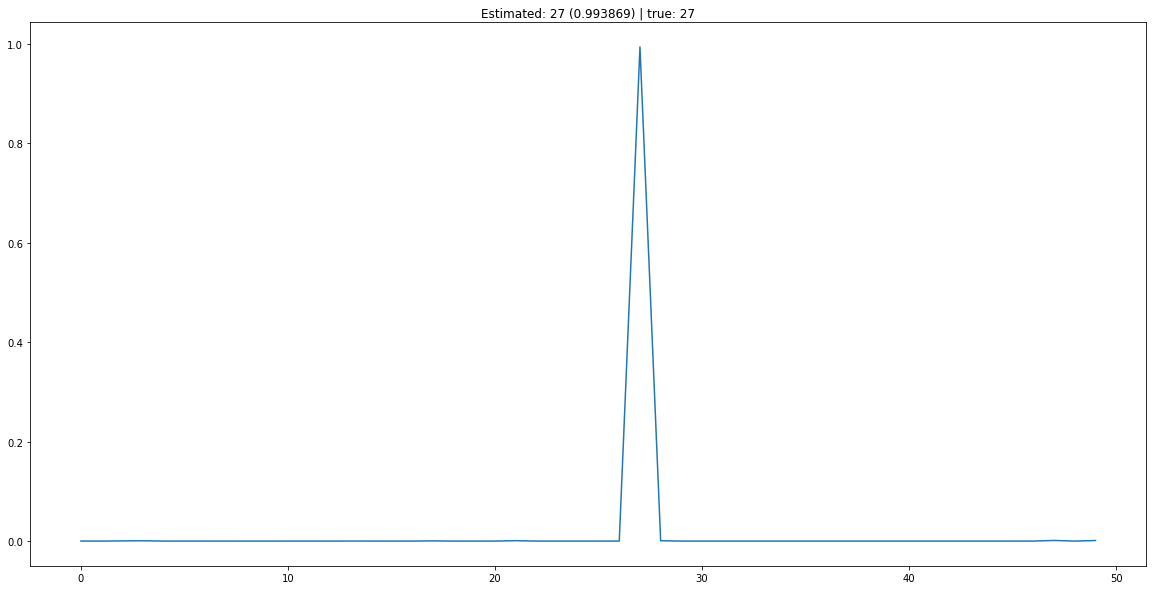

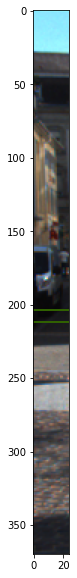

In [41]:
plt.rcParams['figure.figsize'] = [20, 10]

for t in test_generator:
    preds = model.predict(t[0])
    print(list(preds[0]))
    plt.plot(preds[0])
    plt.title('Estimated: %d (%f) | true: %d'%(np.argmax(preds[0]), max(preds[0]),np.argmax(t[1][0])))
    plt.show()
    plt.imshow(t[0][0])
    true = np.argmax(t[1][0])
    pred = np.argmax(preds[0])
    plt.axhline(y=bins[pred],color='red')
    plt.axhline(y=bins[pred+1],color='red')
    plt.axhline(y=bins[true],color='green')
    plt.axhline(y=bins[true+1],color='green')
    plt.show()
    break

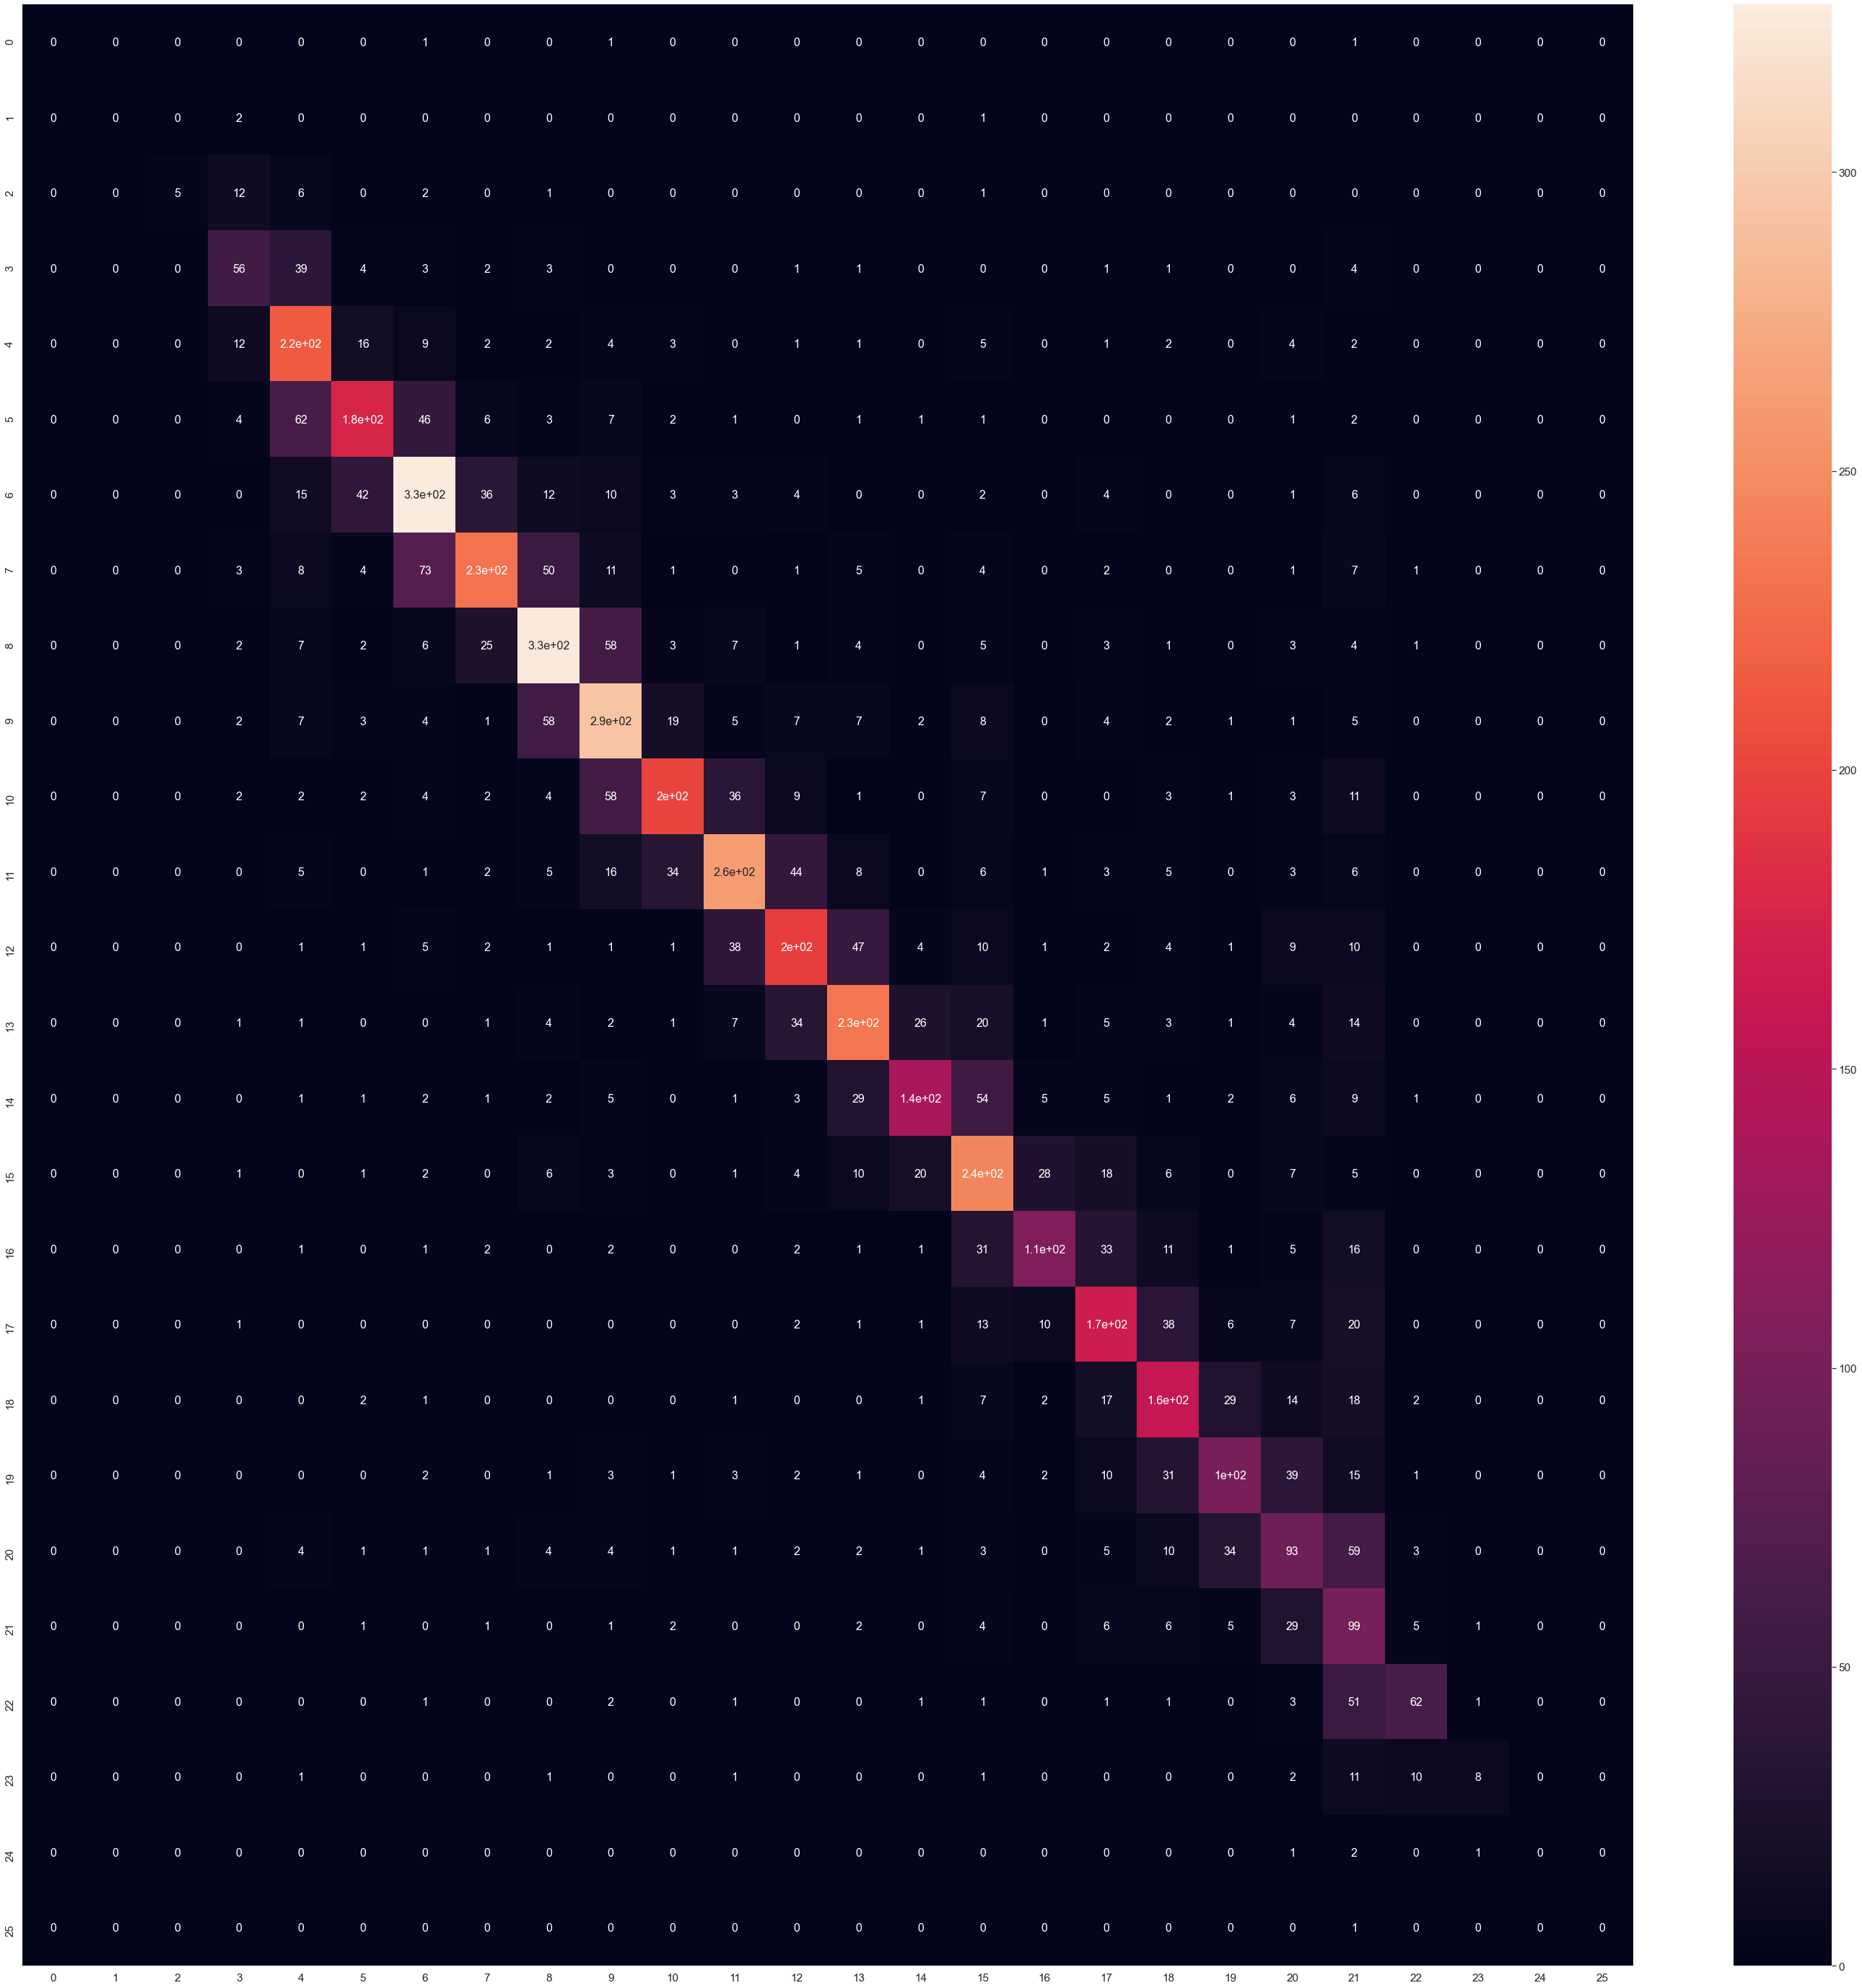

In [74]:
def preds_to_class_pred(preds):
    preds_class = []
    for i in range(len(preds)):
        preds_class.append(np.argmax(preds[i]))
    return preds_class

i = 0
y_pred = []
y_true = []
for t in test_generator:
    y_pred+=preds_to_class_pred(model.predict(t[0]))
    y_true+=preds_to_class_pred(t[1])
    if i>200:
        break
    i+=1

conf_matrix = confusion_matrix(y_true,y_pred)
df_cm = pd.DataFrame(confusion_matrix(y_true,y_pred), range(len(conf_matrix[0])), range(len(conf_matrix)))
plt.figure(figsize=(50,50))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size